In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
import h5py
import time
import pickle
import warnings
import subprocess

from sklearn.decomposition import PCA
from skimage.morphology import convex_hull_image
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.ndimage.filters import gaussian_filter, median_filter, maximum_filter, minimum_filter
from scipy.stats import rankdata
from scipy.ndimage.morphology import distance_transform_edt
from sklearn.cluster import KMeans

from Source.util import getPathsToVisit
from Source.util import get_first_crossing_time, getBBox
from Source.ipythonWidgets import overlayViewer, reconViewer

In [3]:
np.random.seed(42)

In [4]:
train_short = False

In [ ]:
pathsToVisit = getPathsToVisit('../ML/Train')
print('Number of subjects:', len(pathsToVisit))


features_train = []
labels_train = []
for subjectPath in pathsToVisit:
    print(subjectPath)

    # # Load the dataset.
    # reconPath = os.path.join(subjectPath, 'recon_36p_crop.mat')
    # with h5py.File(reconPath) as f:
    #     recon = np.array(f['recon']).T
    # temp_res = 3.0
    # spacing = np.array([1.7, 1.4, 2.4])
    # ss_f = [1, 1, 1, 1]

    # Load the dataset.
    reconPath = os.path.join(subjectPath, 'recon4d.hdf5')
    with h5py.File(reconPath) as f:
        spacing = np.array(f['spacing'])
        temp_res = np.array(f['temp_res']).astype(np.float)/1000
        recon = np.array(f['recon'])
    ss_f = [2, 2, 2, 1]  # Subsampling factor [x,y,z,t]

    recon = recon[::ss_f[0],::ss_f[1],::ss_f[2],::ss_f[3]]
    spacing = np.array([ss_f[0],ss_f[1],ss_f[2]])*spacing
    nx, ny, nz, nt = recon.shape
    
    
    # Load the labels.
    labelsPath = os.path.join(subjectPath, 'labels.hdf5')
    with h5py.File(labelsPath) as f:
        labels3d = np.array(f['labels'])
    labels3d = labels3d[::ss_f[0],::ss_f[1],::ss_f[2]]
    
    # Generate the convex hull for the kidneys
    convex_mask3d = labels3d.copy()
    for cluster_id in [2, 3]:
        cluster = convex_mask3d == cluster_id
        for zz in range(cluster.shape[2]):
            bm = cluster[:,:,zz]
            if np.sum(bm) == 0:
                continue
            bm = convex_hull_image(bm)
            cluster[:,:,zz] = bm > 0
        convex_mask3d[cluster > 0] = cluster_id
    
    
    for cluster_id in [2, 3]:
        ctx_id = cluster_id
        med_id = ctx_id+2
        cs_id = med_id+2
        
        # Calculate the bounding box
        convex_mask = convex_mask3d == cluster_id
        if np.sum(convex_mask) == 0:
            continue
        bbox = getBBox(convex_mask)
        bb_l, bb_h = bbox
        recon_bbox = recon[bb_l[0]:bb_h[0], bb_l[1]:bb_h[1], bb_l[2]:bb_h[2], :].copy()
        labels_bbox = labels3d[bb_l[0]:bb_h[0], bb_l[1]:bb_h[1], bb_l[2]:bb_h[2]].copy()
        convex_mask_bbox = convex_mask[bb_l[0]:bb_h[0], bb_l[1]:bb_h[1], bb_l[2]:bb_h[2]].copy()

        if issubclass(recon_bbox.dtype.type, np.integer):
            recon_bbox -= np.amin(recon_bbox)
            # Use look up table
            lut = np.arange(np.amax(recon_bbox)+1).astype(np.float)
            lut = (lut/np.amax(lut)*255).astype(np.uint8)
            recon_bbox = lut[recon_bbox]
        else:
            recon_bbox -= np.amin(recon_bbox)
            recon_bbox /= np.amax(recon_bbox)
            recon_bbox = (recon_bbox*255).astype(np.uint8)
            
        labels_bbox = labels_bbox*convex_mask_bbox
        labels_bbox[labels_bbox==ctx_id] = 1
        labels_bbox[labels_bbox==med_id] = 2
        labels_bbox[labels_bbox==cs_id] = 3
        labels = labels_bbox.ravel()
        
        sig = recon_bbox.reshape(-1, nt)
        mean_sig = np.mean(sig, axis=0, keepdims=True)

        sample_time = np.array([0, 30, 60, 90, 120, 150, 180]) # seconds after contrast arrives
        t_10p = get_first_crossing_time(mean_sig, 0.10)[0]
        t_10p = np.floor(t_10p).astype(np.int)
        t_start = max(t_10p, 0)
        sample_idx = t_start + np.ceil(sample_time/temp_res).astype(np.int)
        sample_idx[sample_idx > nt-1] = nt-1
        
        if train_short:
            sample_time = np.array([0, 30, 60, 90]) # seconds after contrast arrives
            t_10p = get_first_crossing_time(mean_sig, 0.10)[0]
            t_10p = np.floor(t_10p).astype(np.int)
            t_start = max(t_10p, 0)
            sample_idx = t_start + np.ceil(sample_time/temp_res).astype(np.int)
            sample_idx[sample_idx > nt-1] = nt-1
            sig = sig[:,:sample_idx[-1]+1]
        
        sig_sample = sig[:,sample_idx].astype(np.float).copy()
        
        sig_min = np.amin(sig, axis=1, keepdims=True)
        sig_max = np.amax(sig, axis=1, keepdims=True)
        sig_diff = sig_max - sig_min
        sig_sample = np.hstack((sig_sample, sig_diff))
        
        
#         for ff in range(sig_sample.shape[1]):
#             sig_sample[:,ff] = rankdata(sig_sample[:,ff])/sig_sample.shape[0]
        
        sig_sample -= np.mean(sig_sample, axis=0, keepdims=True)
        sig_sample /= np.std(sig_sample, axis=0, keepdims=True)

        t_ref = get_first_crossing_time(mean_sig, 0.10)[0]
        t_50p = (get_first_crossing_time(sig, 0.50) - t_ref)*temp_res
        t_90p = (get_first_crossing_time(sig, 0.90) - t_ref)*temp_res
        t_feat = np.vstack((t_50p, t_90p)).T
        
        
#         t_dist = []
#         for i in range(t_feat.shape[1]):
#             t_select = t_feat[:,i].copy()
#             t_select[convex_mask_bbox.ravel()==0] = np.amin(t_select)
#             kmeans = KMeans(n_clusters=4)
#             t_select_dist= kmeans.fit_transform(t_select.reshape(-1,1))
#             cluster_centers = kmeans.cluster_centers_.copy()
#             relabel = rankdata(cluster_centers, method='ordinal').astype(np.int)-1
#             t_select_dist_reordered = np.zeros_like(t_select_dist)
#             for j in range(t_select_dist.shape[1]):
#                 t_select_dist_reordered[:,relabel[j]] = t_select_dist[:,j]
#             t_dist.append(t_select_dist_reordered)
#         t_dist = np.hstack(t_dist) 
        
        
        dist = distance_transform_edt(convex_mask_bbox, sampling=spacing).reshape(-1,1)
        
        features = np.hstack((sig_sample, t_feat, dist))
        
#         num_samples_select = 10000
#         select_idx = np.random.choice(np.arange(features.shape[0]), size=num_samples_select, replace=True)
#         features_sel = features[select_idx, :]
#         labels_sel = labels[select_idx]
        
        features_train.append(features)
        labels_train.append(labels)

features_train = np.vstack(features_train)
labels_train = np.hstack(labels_train)

outputPath = os.path.join('..', 'ML', 'train.hdf5')
with h5py.File(outputPath, 'w') as f:
    dset = f.create_dataset('features', data=features_train, compression='gzip')
    dset = f.create_dataset('labels', data=labels_train, compression='gzip')

In [5]:
inputPath = os.path.join('..', 'ML', 'train.hdf5')
with h5py.File(inputPath) as f:
    features_all = np.array(f['features'])
    labels_all = np.array(f['labels'])

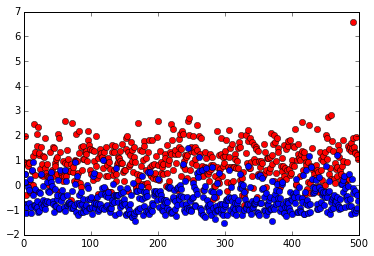

In [6]:
plt.figure()
num_select = 1000
feat = 7
idx_pos = np.random.choice(np.where(labels_all==1)[0], num_select//2)
idx_neg = np.random.choice(np.where(labels_all==0)[0], num_select//2)
plt.plot(features_all[idx_pos,feat], 'ro')
plt.plot(features_all[idx_neg,feat], 'bo')

In [7]:
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.cross_validation import train_test_split

In [16]:
# # Split the dataset in two equal parts
# X_train, X_test, y_train, y_test = train_test_split(
#     features_all, labels_all, test_size=0.989, random_state=3)
# print(X_train.shape)

(10177, 11)


In [17]:
# classifier = SVC(kernel='linear', C=10)
# classifier = SVC(kernel='rbf', C=10)
classifier = SVC(kernel='rbf', C=10, gamma=0.1)

num_select = 10000
np.random.seed(42)
idx_sel = np.random.choice(np.arange(features_all.shape[0]), num_select)
features_sel = features_all[idx_sel,:]
labels_sel = labels_all[idx_sel]

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    features_sel, labels_sel, test_size=0.5, random_state=3)

X_mean = np.mean(X_train, axis=0, keepdims=True)
X_std = np.std(X_train, axis=0, keepdims=True)
X_train -= X_mean
X_train /= X_std
X_test -= X_mean
X_test /= X_std


classifier.fit(X_train, y_train)
pred_train = classifier.predict(X_train)
pred_test = classifier.predict(X_test)

print(classification_report(y_train, pred_train))
print(classification_report(y_test, pred_test))

             precision    recall  f1-score   support

          0       0.97      0.97      0.97      6429
          1       0.85      0.91      0.88      2410
          2       0.79      0.64      0.71       725
          3       0.85      0.85      0.85       613

avg / total       0.93      0.93      0.92     10177

             precision    recall  f1-score   support

          0       0.97      0.96      0.97    579329
          1       0.84      0.90      0.87    213660
          2       0.77      0.64      0.70     69858
          3       0.80      0.79      0.80     52159

avg / total       0.91      0.91      0.91    915006



In [11]:
import pickle

model = {}
model['classifier'] = classifier
model['mean'] = X_mean
model['std'] = X_std

if train_short:
    model_filename = os.path.join(os.getcwd(), '../Model', 'subsegment_model_90.pkl')
else:
    model_filename = os.path.join(os.getcwd(), '../Model', 'subsegment_model_180.pkl')

with open(model_filename, 'wb') as f:
    pickle.dump(model, f)

In [12]:
with open(model_filename, 'rb') as f:
    model2 = pickle.load(f)

In [13]:
model2

{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.1,
   kernel='rbf', max_iter=-1, probability=False, random_state=None,
   shrinking=True, tol=0.001, verbose=False),
 'mean': array([[ -1.18583635e-02,   2.85547461e-03,  -3.96282764e-05,
          -2.48503487e-03,  -4.79743522e-03,  -4.39042059e-03,
          -8.10190040e-03,  -3.52822405e-03,   2.55660161e+01,
           9.52287179e+01,   2.99967905e+00]]),
 'std': array([[  0.99873599,   0.99666075,   0.99358505,   0.98681498,
           0.99222262,   0.9882177 ,   0.99164924,   0.99317097,
          45.28821426,  74.90282987,   4.89445245]])}

In [9]:
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
import warnings

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    features_sel, labels_sel, test_size=0.5, random_state=3)
X_mean = np.mean(X_train, axis=0, keepdims=True)
X_std = np.std(X_train, axis=0, keepdims=True)
X_train -= X_mean
X_train /= X_std
X_test -= X_mean
X_test /= X_std
X_all = np.vstack((X_train, X_test))
y_all = np.hstack((y_train, y_test))

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.01, 0.1, 1],
                     'C': [1, 10, 100]},
#                     {'kernel': ['linear'], 'C': [1, 10]},
                   ]
scores = ['f1']
# scores = ['f1', 'precision', 'recall']

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        if 'custom' in score:
            clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5, scoring=scorer)
        else:
            clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5, 
                               scoring='%s_weighted' % score)
        
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        for params, mean_score, scores in clf.grid_scores_:
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean_score, scores.std() * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()
        
        
        print("The model is trained on the full development set.")
        print("The scores are computed on the full data set.")
        print()
        y_true, y_pred = y_all, clf.predict(X_all)
        print(classification_report(y_true, y_pred))
        print()

# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'gamma': 0.1, 'C': 10, 'kernel': 'rbf'}

Grid scores on development set:

0.875 (+/-0.016) for {'gamma': 0.01, 'C': 1, 'kernel': 'rbf'}
0.891 (+/-0.015) for {'gamma': 0.1, 'C': 1, 'kernel': 'rbf'}
0.887 (+/-0.018) for {'gamma': 1, 'C': 1, 'kernel': 'rbf'}
0.889 (+/-0.015) for {'gamma': 0.01, 'C': 10, 'kernel': 'rbf'}
0.900 (+/-0.011) for {'gamma': 0.1, 'C': 10, 'kernel': 'rbf'}
0.883 (+/-0.013) for {'gamma': 1, 'C': 10, 'kernel': 'rbf'}
0.895 (+/-0.012) for {'gamma': 0.01, 'C': 100, 'kernel': 'rbf'}
0.896 (+/-0.013) for {'gamma': 0.1, 'C': 100, 'kernel': 'rbf'}
0.868 (+/-0.015) for {'gamma': 1, 'C': 100, 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.98      0.96      0.97      3218
          1       0.84      0.91      0.87   

In [61]:
# Load a full dataset and test the classifier

# pathsToVisit = getPathsToVisit('../ML/Train')
pathsToVisit = getPathsToVisit('../Data3')
print('Number of subjects:', len(pathsToVisit))

features_train = []
labels_train = []
subjectPath = pathsToVisit[0]
print(subjectPath)


# # Load the dataset.
# reconPath = os.path.join(subjectPath, 'recon_36p_crop.mat')
# with h5py.File(reconPath) as f:
#     recon = np.array(f['recon']).T
# temp_res = 3.0
# spacing = np.array([1.7, 1.4, 2.4])
# ss_f = [1, 1, 1, 1]


# # Load the dataset.
# reconPath = os.path.join(subjectPath, 'recon4d.hdf5')
# with h5py.File(reconPath) as f:
#     spacing = np.array(f['spacing'])
#     temp_res = np.array(f['temp_res']).astype(np.float)/1000
#     recon = np.array(f['recon'])
# ss_f = [2, 2, 2, 1]  # Subsampling factor [x,y,z,t]


# Load the dataset.
reconPath = os.path.join(subjectPath, 'recon4d.hdf5')
with h5py.File(reconPath) as f:
    spacing = np.array(f['spacing'])
    temp_res = np.array(f['temp_res']).astype(np.float)/1000
    recon = np.array(f['recon'])
ss_f = [1, 1, 1, 1]


recon = recon[::ss_f[0],::ss_f[1],::ss_f[2],::ss_f[3]]
spacing = np.array([ss_f[0],ss_f[1],ss_f[2]])*spacing
nx, ny, nz, nt = recon.shape


# Load the labels.
labelsPath = os.path.join(subjectPath, 'labels.hdf5')
with h5py.File(labelsPath) as f:
    labels3d = np.array(f['labels'])
labels3d = labels3d[::ss_f[0],::ss_f[1],::ss_f[2]]

# Generate the convex hull for the kidneys
convex_mask3d = labels3d.copy()
for cluster_id in [2, 3]:
    cluster = convex_mask3d == cluster_id
    for zz in range(cluster.shape[2]):
        bm = cluster[:,:,zz]
        if np.sum(bm) == 0:
            continue
        bm = convex_hull_image(bm)
        cluster[:,:,zz] = bm > 0
    convex_mask3d[cluster > 0] = cluster_id

Number of subjects: 4
/Users/umityoruk/Documents/PythonDev/NewSegmentation/Data3/01


In [62]:
prediction3d = np.zeros((nx, ny, nz), dtype=np.int)
for cluster_id in [2, 3]:
    ctx_id = cluster_id
    med_id = ctx_id+2
    cs_id = med_id+2

    # Calculate the bounding box
    convex_mask = convex_mask3d == cluster_id
    if np.sum(convex_mask) == 0:
        continue
    bbox = getBBox(convex_mask)
    bb_l, bb_h = bbox
    recon_bbox = recon[bb_l[0]:bb_h[0], bb_l[1]:bb_h[1], bb_l[2]:bb_h[2], :].copy()
    labels_bbox = labels3d[bb_l[0]:bb_h[0], bb_l[1]:bb_h[1], bb_l[2]:bb_h[2]].copy()
    convex_mask_bbox = convex_mask[bb_l[0]:bb_h[0], bb_l[1]:bb_h[1], bb_l[2]:bb_h[2]].copy()
    nx_bb, ny_bb, nz_bb = convex_mask_bbox.shape

    if issubclass(recon_bbox.dtype.type, np.integer):
        recon_bbox -= np.amin(recon_bbox)
        # Use look up table
        lut = np.arange(np.amax(recon_bbox)+1).astype(np.float)
        lut = (lut/np.amax(lut)*255).astype(np.uint8)
        recon_bbox = lut[recon_bbox]
    else:
        recon_bbox -= np.amin(recon_bbox)
        recon_bbox /= np.amax(recon_bbox)
        recon_bbox = (recon_bbox*255).astype(np.uint8)

    labels_bbox = labels_bbox*convex_mask_bbox
    labels_bbox[labels_bbox==ctx_id] = 1
    labels_bbox[labels_bbox==med_id] = 2
    labels_bbox[labels_bbox==cs_id] = 3
    labels = labels_bbox.ravel()

    sig = recon_bbox.reshape(-1, nt)
    mean_sig = np.mean(sig, axis=0, keepdims=True)

    sample_time = np.array([0, 30, 60, 90, 120, 150, 180]) # seconds after contrast arrives
    t_10p = get_first_crossing_time(mean_sig, 0.10)[0]
    t_10p = np.floor(t_10p).astype(np.int)
    t_start = max(t_10p, 0)
    sample_idx = t_start + np.ceil(sample_time/temp_res).astype(np.int)
    cutoff_idx = np.amax(np.where(sample_idx <= nt-1)[0])
    temp_cutoff = sample_time[cutoff_idx]
    print(temp_cutoff, 'seconds')
    sample_idx[sample_idx > nt-1] = nt-1
    
    
    if train_short:
            sample_time = np.array([0, 30, 60, 90]) # seconds after contrast arrives
            t_10p = get_first_crossing_time(mean_sig, 0.10)[0]
            t_10p = np.floor(t_10p).astype(np.int)
            t_start = max(t_10p, 0)
            sample_idx = t_start + np.ceil(sample_time/temp_res).astype(np.int)
            sample_idx[sample_idx > nt-1] = nt-1
            sig = sig[:,:sample_idx[-1]+1]


    sig_sample = sig[:,sample_idx].astype(np.float).copy()
    
    sig_min = np.amin(sig, axis=1, keepdims=True)
    sig_max = np.amax(sig, axis=1, keepdims=True)
    sig_diff = sig_max - sig_min
    sig_sample = np.hstack((sig_sample, sig_diff))


#     for ff in range(sig_sample.shape[1]):
#         sig_sample[:,ff] = rankdata(sig_sample[:,ff])/sig_sample.shape[0]

    sig_sample -= np.mean(sig_sample, axis=0, keepdims=True)
    sig_sample /= np.std(sig_sample, axis=0, keepdims=True)

    t_ref = get_first_crossing_time(mean_sig, 0.10)[0]
    t_50p = (get_first_crossing_time(sig, 0.50) - t_ref)*temp_res
    t_90p = (get_first_crossing_time(sig, 0.90) - t_ref)*temp_res

    t_feat = np.vstack((t_50p, t_90p)).T
    
#     t_dist = []
#     for i in range(t_feat.shape[1]):
#         t_select = t_feat[:,i].copy()
#         t_select[convex_mask_bbox.ravel()==0] = np.amin(t_select)
#         kmeans = KMeans(n_clusters=4)
#         t_select_dist= kmeans.fit_transform(t_select.reshape(-1,1))
#         cluster_centers = kmeans.cluster_centers_.copy()
#         relabel = rankdata(cluster_centers, method='ordinal').astype(np.int)-1
#         t_select_dist_reordered = np.zeros_like(t_select_dist)
#         for j in range(t_select_dist.shape[1]):
#             t_select_dist_reordered[:,relabel[j]] = t_select_dist[:,j]
#         t_dist.append(t_select_dist_reordered)
#     t_dist = np.hstack(t_dist)

    dist = distance_transform_edt(convex_mask_bbox, sampling=spacing).reshape(-1,1)
    
    features = np.hstack((sig_sample, t_feat, dist))
    
    X_test = features.copy()
    y_test = labels.copy()
    
    X_test -= X_mean
    X_test /= X_std

    pred_test = classifier.predict(X_test)
    
    pred_test = pred_test*convex_mask_bbox.ravel()

    print(classification_report(y_test, pred_test))
    
    pred_labels3d = pred_test.reshape(nx_bb, ny_bb, nz_bb)
    
    prediction3d_bbox = prediction3d[bb_l[0]:bb_h[0], bb_l[1]:bb_h[1], bb_l[2]:bb_h[2]]
    prediction3d_bbox[pred_labels3d > 0] = pred_labels3d[pred_labels3d > 0]

180 seconds
             precision    recall  f1-score   support

          0       0.94      0.97      0.95     27752
          1       0.89      0.85      0.87     16530
          2       0.52      0.42      0.46      1919
          3       0.43      0.51      0.46       839

avg / total       0.89      0.90      0.89     47040

180 seconds
             precision    recall  f1-score   support

          0       0.95      0.98      0.97     15031
          1       0.87      0.82      0.84      5430
          2       0.73      0.54      0.62      1092
          3       0.36      0.36      0.36       255

avg / total       0.91      0.91      0.91     21808



In [65]:
overlayViewer(recon, prediction3d, zz=nz//4, tt=nt//2)

In [64]:
overlayViewer(recon, labels3d, zz=nz//4, tt=nt//2)